In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

2024-04-06 17:36:15.937588: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load scraped data
df = pd.read_csv('scraped_data/BABE_scraped.csv')

df['content'] = df['content'].str.lower() # Avoid repeated words

df.head()

,Unnamed: 0,url,content,type_class
0,0,https://www.foxnews.com/entertainment/australi...,"""orange is the new black"" star yael stone is r...",2
1,1,https://www.alternet.org/2020/06/law-and-order...,mark twain's instruction to curious residents ...,0
2,2,https://www.nbcnews.com/news/latino/after-step...,it wasn't the content of white house adviser s...,0
3,3,https://www.alternet.org/2019/07/fox-news-has-...,donald trump thinks white nationalism is going...,0
4,4,https://www.alternet.org/2019/08/a-new-low-was...,"on saturday, august 3, el paso became the scen...",0


In [4]:
# Tokenize
tokenizer = Tokenizer(num_words=5000) # adjustable
tokenizer.fit_on_texts(df['content'])

sequences = tokenizer.texts_to_sequences(df['content'])
max_sequence_length = 500

# Training data
X = pad_sequences(sequences, maxlen=max_sequence_length)
y = df['type_class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# RUN THIS IF RETRAINING TO WIPE BACKEND WEIGHTS 
# do not need to run on first run

from tensorflow.keras import backend as K
K.clear_session()

In [38]:
# BASE LSTM
# Use this model to experiment with other architectures

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

num_classes = 3
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)

# Model architecture
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128))
model.add(LSTM(128, return_sequences=False))
#model.add(Bidirectional(LSTM(128))) # Bidirectional model seems to perform worse, however data sample size was very small when tested
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Training
history = model.fit(X_train, y_train_one_hot, epochs=25, batch_size=32, validation_data=(X_test, y_test_one_hot))

# Eval
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Test Accuracy: {accuracy:.2f}')


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - accuracy: 0.4333 - loss: 1.0951 - val_accuracy: 0.3333 - val_loss: 1.0846
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.7919 - loss: 1.0645 - val_accuracy: 0.3333 - val_loss: 1.0683
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7890 - loss: 1.0269 - val_accuracy: 0.3333 - val_loss: 1.0434
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8203 - loss: 0.9756 - val_accuracy: 0.2500 - val_loss: 0.9969
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6509 - loss: 0.8879 - val_accuracy: 0.2500 - val_loss: 0.9753
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.4863 - loss: 0.8383 - val_accuracy: 0.5000 - val_loss: 0.8904
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8486 - loss: 0.7525 - val_accuracy: 0.7500 - val_loss: 0.8785
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8590 - loss: 0.7167 - val_accuracy: 0.6667 - val_loss:

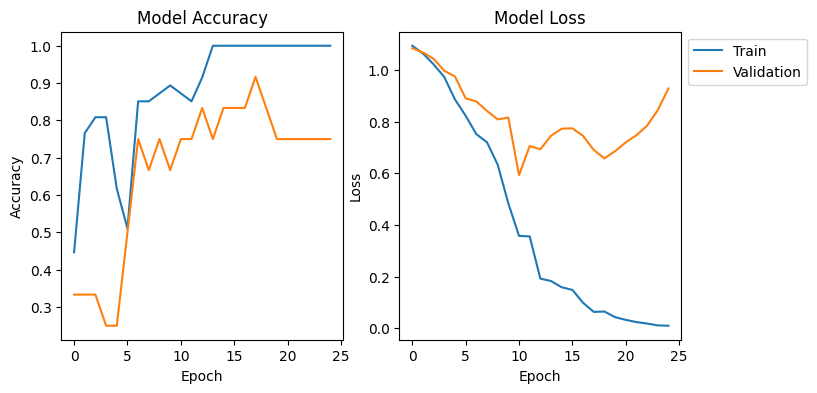

In [39]:
import matplotlib.pyplot as plt


# Accuracy plot
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)  # First subplot in a 1x2 grid
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Loss plot
plt.subplot(1, 2, 2)  # Second subplot in a 1x2 grid
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1, 1))

plt.show()